In [1]:
import hypothesis
import numpy as np
import matplotlib.pyplot as plt
import torch

from IPython.display import Video
from tqdm import tqdm

## Problem setting

Posterior inference with an intractable likelihood is becoming an increasingly common task in scientific domains which rely on sophisticated computer simulations. Typically, these forward models do not admit tractable densities forcing practitioners to rely on approximations. In this tutorial we focus on a likelihood-free, machine learning based analysis pipeline, which automatically learns a mapping between the sythethic observables $x$ produced by the simulator, and its input parameters $\vartheta$ by solving a tractable minimization problem.

<br><br><br>**Let's begin!**

In [2]:
Video("https://joerihermans.com/galton.mp4")

The Galton board, or bean machine, is a device which demonstrates the central limit theorem. Here, a ball is dropped from a dispenser and (in an idealised Galton board) ends up in the $k$-th = $n$-th bin if the ball bounced $k$ times to the right. The probability that a ball ends up in the $k$-th bin, given a probability of bouncing right on a pin $\vartheta$ is given by the analytical form
$$
p(k\text{-th bin}\vert\vartheta) = {{n}\choose{k}}\vartheta^k(1-\vartheta)^{n-k}.
$$

**But what if we remove a pin, or change their layout?**
<br><br><br>
The Galton board can be viewed as a *metaphor* of a simulator. The probability of bouncing to the right is parameterized by a parameter of interest $\vartheta$ (which we want to infer). Dropping a ball from the dispenser corresponds to a *stochastic* execution of the simulator (code), or drawing a sample from the likelihood *model*: $x\sim p(x\vert\vartheta)$. Which is easy *and tractable*, because this simply corresponds to running your simulation code.

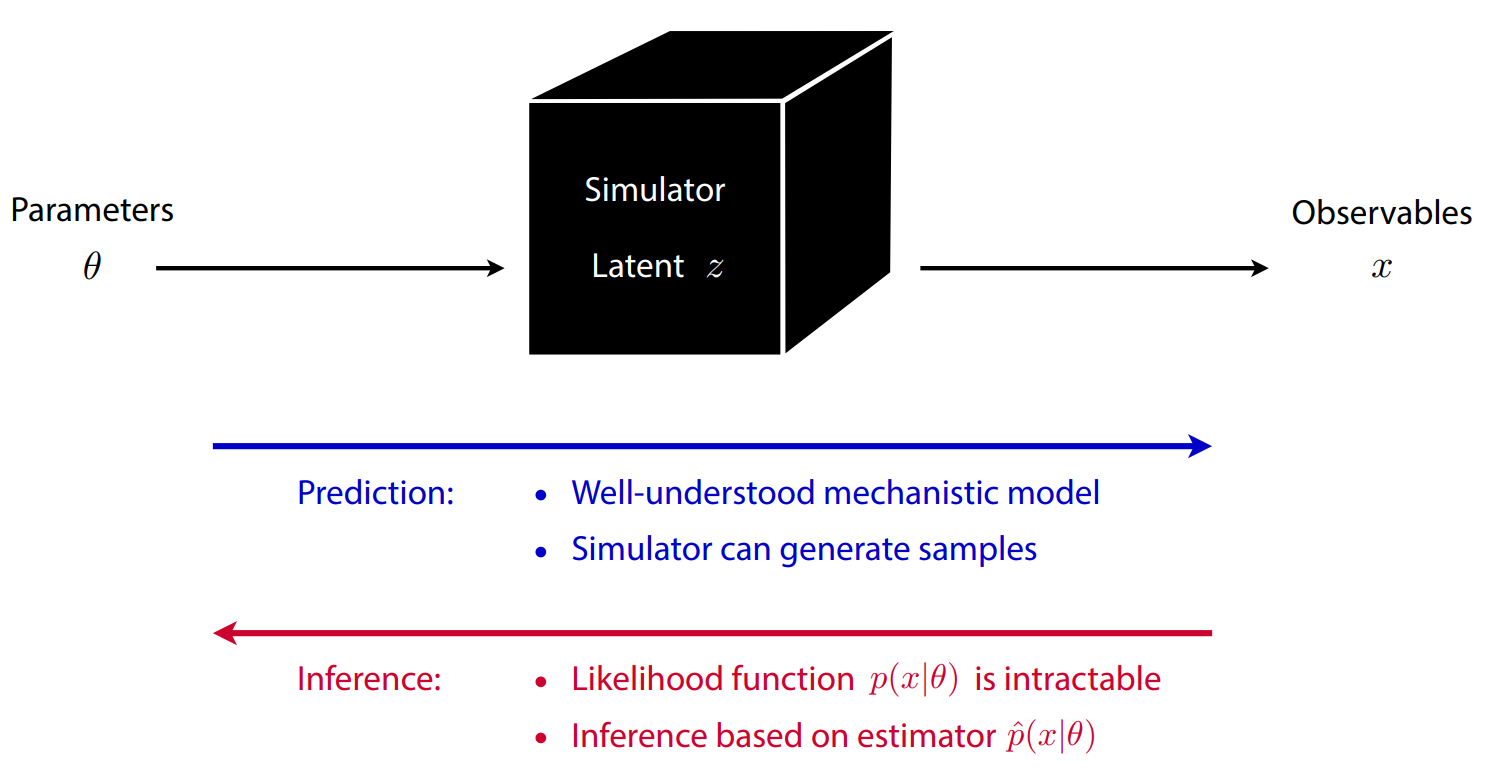

*Credit: Johann Brehmer*

To compute the likelihood of a ball falling into the $k$-th given $\vartheta$, we would need to integrate over all possible execution paths **implicitely** defined by computer code which gives rise to a ball dropping into the $k$-th bin. Although this seems reasonble for a regular Galton board, consider the scenario where there are thousands of rows. Clearly, this is **intractable**

To infer some knowledge about $\vartheta$, one needs **ingredients** such as:

 - the likelihood $p(x\vert\vartheta)$, 
 - the likelihood ratio $r(x\vert\vartheta_0,\vartheta_1)$,
 - or the posterior $p(\vartheta\vert x)$.
 
However, in the simulation-based scenario, each of these ingredients **cannot** be tractibly evaluated and are therefore not available at training time. We therefore have to rely on techniques which compute **approximations** to one, or multiple, of these ingredients to infer some knowledge about the parameter(s) $\vartheta$ given an *observable* x.



## Bayesian inference through ratio estimation

Notice that Bayes' rule can be factorized into the product of the prior and the likelihood-to-evidence ratio:

$$
p(\vartheta\vert x) = p(\vartheta)\frac{p(x\vert\vartheta)}{p(x)}.
$$

Evaluating the posterior density for a given target parameter $\vartheta$ and
an observable $x$ in our setting is not possible because the likelihood $p(x\vert\vartheta$ is per definition intractable. To enable the tractable evaluation of the posterior, we have to rely on likelihood-free surrogates for key components in Bayes’ rule.

Notice that the *intractable* likelihood to evidence ratio can be expressed as:

$$
\frac{p(x\vert\vartheta)p(\vartheta)}{p(x)p(\vartheta)} = \frac{p(\vartheta,x)}{p(\vartheta)p(x)}.
$$

Since classification is essentially *density-ratio* estimation, the idea is to essentially train a classifier or discriminator with inputs $\vartheta$ and $x$, $d(\vartheta, x)$ to discriminate between samples from the joint $p(\vartheta,x)$ and samples from the product of marginals $p(\vartheta)p(x)$. You can show that whenever the training criterion has been minimized, the optimal discriminator models the Bayes optimal decision function

$$
d(\vartheta, x) = \frac{p(\vartheta, x)}{p(\vartheta,x) + p(\vartheta)p(x)},
$$

which can be transformed into the likelihood-to-evidence ratio $r(x\vert\vartheta)$ as

$$
r(x\vert\vartheta) = \frac{1 - d(\vartheta,x)}{d(\vartheta, x)} = \frac{p(\vartheta,x)}{p(\vartheta)p(x)} = \frac{p(x\vert\vartheta)}{p(x)}.
$$

Then, the posterior density function can be approximated as

$$
\log\hat{p}(\vartheta\vert x) = \log p(\vartheta) + \log\text{logit}(d(\vartheta, x)),
$$
since

$$
\text{logit}(d(\vartheta, x)) = \log r(x\vert\vartheta).
$$

I would always recommend to use the logit (log ratio), as these have much nicer properties when backpropagating through the ratio estimator (no vanishing gradients do to sigmoidal operation). For instance:

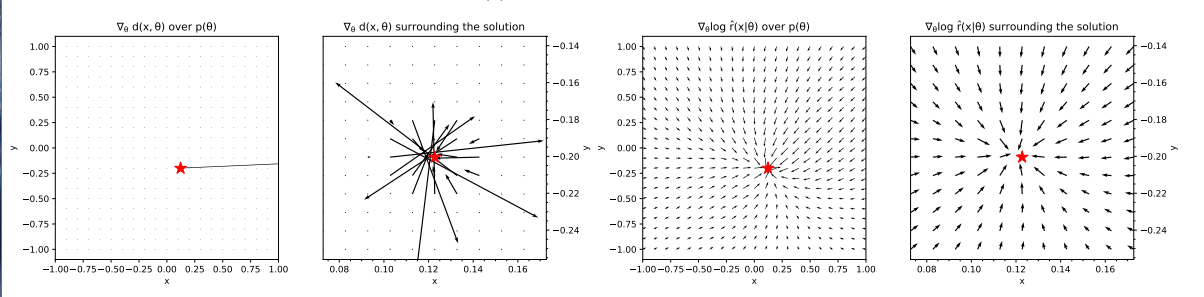

### Minimal example

To make the execution time of this notebook reasonable, let's consider a likelihood model (simulator) $\mathcal{N}(\vartheta, 1)$ with prior $p(\vartheta)\triangleq\mathcal{U}(-15, 15)$.

In [3]:
from hypothesis.benchmark.normal import Simulator
from hypothesis.benchmark.normal.util import Uniform

prior = Uniform(-15, 15)
simulator = Simulator()

#### Simulations

Simply define a certain number of simulations (this does have an effect on the posterior approximation!).

In [4]:
n = 1000000 # Number of simulations

Draw samples from the prior.

In [5]:
inputs = prior.sample((n,))
inputs = inputs.view(-1, 1)

Simulate, i.e., draw samples from the forward model.

In [6]:
outputs = simulator(inputs)

Jointly, these represent samples from the joint $p(\vartheta, x)$.

In [7]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(inputs, outputs)

#### Ratio estimator

Defining a ratio estimator is fairly trivial. Personally, I always take to convention to define a `log_ratio` method which outputs $\log r(x\vert\vartheta)$.

In [8]:
class RatioEstimator(torch.nn.Module):
    
    def __init__(self):
        super(RatioEstimator, self).__init__()
        h = 2048
        self.trunk = torch.nn.Sequential(
            torch.nn.Linear(2, h),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h, h),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h, h),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h, 1)
        )
        
    def forward(self, inputs, outputs):
        log_ratios = self.log_ratio(inputs, outputs)
        
        return log_ratios, log_ratios.sigmoid()
    
    def log_ratio(self, inputs, outputs):
        inputs = inputs.view(-1, 1)
        outputs = outputs.view(-1, 1)
        z = torch.cat([inputs, outputs], dim=1)
        
        return self.trunk(z) # logits d(inputs, outputs) -> log r(outputs | inputs)

#### Training

The training procedure is fairly straightforward as well.

Definition of the batch-size and the targets:

In [9]:
batch_size = 8192

ones = torch.ones(batch_size, 1)
zeros = torch.zeros(batch_size, 1)

ones = ones.cuda()
zeros = zeros.cuda()

**Tip**: It seems that a larger batch-size seems to be preferred (larger posterior probabilities of the nominal target parameters, in expectation).

**Tip**: Instead of drawning new samples from the product of marginals, simply shuffle the same elements along the batch axes. This **really** helps! Although we don't really know why.

Allocate the ratio estimator and move it to the GPU:

In [10]:
d = RatioEstimator()
d = d.cuda()
d.train()

RatioEstimator(
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)

Allocation of the optimizer and the criterion:

In [11]:
optimizer = torch.optim.Adam(d.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

Training loop (without test dataset):

100%|██████████| 122/122 [00:16<00:00,  7.35it/s]


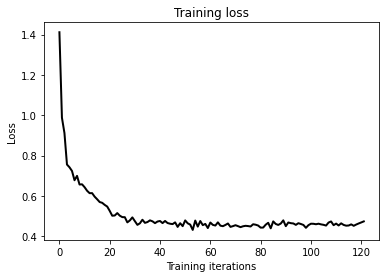

In [12]:
from torch.utils.data import DataLoader

epochs = 1
losses = []

for _ in range(epochs):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    for batch in tqdm(iter(loader)):
        inputs, outputs = batch
        # Draw a sample from the joint p(inputs, outputs).
        inputs = inputs.cuda()
        outputs = outputs.cuda()
        _, out = d(inputs, outputs)
        loss_joint = criterion(out, ones)
        
        # A sample from the product of marginals is drawn by simply shuffling along the batch axis.
        inputs = inputs[torch.randperm(inputs.size()[0])]
        _, out = d(inputs, outputs)
        loss_marginals = criterion(out, zeros)
        
        # Combine the losses and apply a backpropagation step
        optimizer.zero_grad()
        loss = loss_joint + loss_marginals
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
d = d.eval()
        
plt.plot(losses, lw=2, color="black")
plt.title("Training loss")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.show()

#### Inference

Move the ratio estimator to the CPU (can stay on GPU though)

In [13]:
ratio_estimator = d.cpu()

Sample a truth and an observable for testing:

In [14]:
truth = prior.sample()
x_o = simulator(truth)

Define the space we're going to compute the posterior over. We'll simply be *scanning* the posterior density function.

In [15]:
resolution = 100
inputs = torch.linspace(-15, 15, resolution)
outputs = x_o.repeat(resolution, 1)

Evaluate the approximate log posterior for the specified space.

In [16]:
log_ratios = ratio_estimator.log_ratio(inputs, outputs)
prior = torch.distributions.uniform.Uniform(-15, 15.01)

log_posterior = prior.log_prob(inputs).view(-1, 1) + log_ratios

Plot the results!

In [17]:
inputs = inputs.view(-1).detach().numpy()
log_posterior = log_posterior.view(-1).detach().numpy()

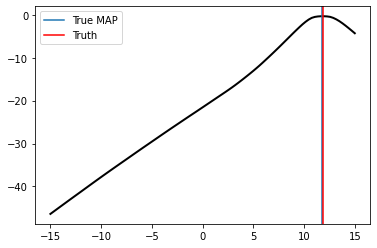

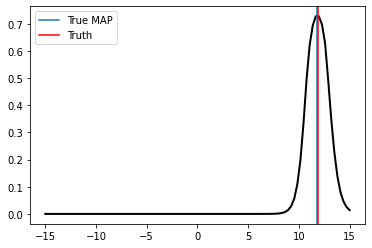

In [18]:
plt.plot(inputs, log_posterior, lw=2, color="black")
plt.axvline(x_o, color="C0", label="True MAP")
plt.axvline(truth, color="red", label="Truth")
plt.legend()
plt.show()

plt.plot(inputs, np.exp(log_posterior), lw=2, color="black")
plt.axvline(x_o, color="C0", label="True MAP")
plt.axvline(truth, color="red", label="Truth")
plt.legend()
plt.show()

The amortisation of the estimation of the ratio allows us to compute the posterior of arbitrary observables.

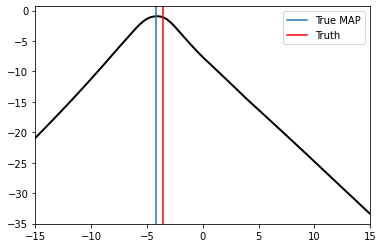

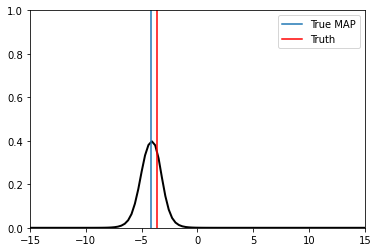

In [19]:
truth = prior.sample()
x_o = simulator(truth)

inputs = torch.linspace(-15, 15, resolution)
outputs = x_o.repeat(resolution, 1)

log_ratios = ratio_estimator.log_ratio(inputs, outputs)
log_posterior = prior.log_prob(inputs).view(-1, 1) + log_ratios

inputs = inputs.view(-1).detach().numpy()
log_posterior = log_posterior.view(-1).detach().numpy()

plt.plot(inputs, log_posterior, lw=2, color="black")
plt.axvline(x_o, color="C0", label="True MAP")
plt.axvline(truth, color="red", label="Truth")
plt.xlim([-15, 15])
plt.legend()
plt.show()

plt.plot(inputs, np.exp(log_posterior), lw=2, color="black")
plt.axvline(x_o, color="C0", label="True MAP")
plt.axvline(truth, color="red", label="Truth")
plt.xlim([-15, 15])
plt.ylim([0, 1])
plt.legend()
plt.show()

Traditional likelihood-ratio or hypothesis testing is also possible, using the same pretrained (albeit Bayesian) ratio estimator. Say we pick as a reference hypothesis $\vartheta_\text{ref} = -2.5$.

In [20]:
theta_ref = -2.5

Notice that the likelihood-ratio statistic can be computed as

$$
\frac{p(x\vert\vartheta)}{p(x\vert\vartheta_\text{ref})} = \frac{\displaystyle\frac{p(x\vert\vartheta)}{p(x)}}{\displaystyle\frac{p(x\vert\vartheta_\text{ref})}{p(x)}} = \frac{r(x\vert\vartheta)}{r(x\vert\vartheta_\text{ref})},
$$
because the evidence terms cancel each other out.

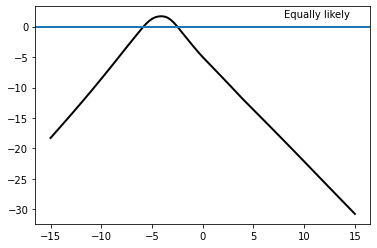

In [21]:
inputs = torch.linspace(-15, 15, resolution)
inputs_reference = torch.tensor(theta_ref).repeat(resolution, 1)
outputs = x_o.repeat(resolution, 1)

log_likelihood_ratios = ratio_estimator.log_ratio(inputs, outputs) - ratio_estimator.log_ratio(inputs_reference, outputs)

plt.plot(inputs.numpy(), log_likelihood_ratios.detach().numpy(), color="black", lw=2)
plt.text(8, 1.5, r"Equally likely")
plt.axhline(0, color="C0", lw=2)
plt.show()

## Markov chain Monte Carlo

Markov chain Monte Carlo (MCMC) is typically applied in practice because the the *evidence* $p(x)$ is intractable. The idea here is to evolve a Markov chain which transitions from a current state $\vartheta_t$ to a proposed state $\vartheta$. The way the proposal is generated depends on the algorithm at hand. but the way the quality of a transition is assessed is virtually always the same. That it, it relies on the likelihood ratio

$$
\frac{p(\vartheta)p(x\vert\vartheta)}{p(\vartheta_t)p(x\vert\vartheta_t)} = \frac{p(\vartheta)r(x\vert\vartheta)}{p(\vartheta_t)r(x\vert\vartheta_t)}.
$$

### A simple Metropolis-Hastings sampler

In [22]:
def compute_log_ratio(proposed_theta, theta, x):
    return prior.log_prob(proposed_theta).item() + ratio_estimator.log_ratio(proposed_theta, x) - prior.log_prob(theta) - ratio_estimator.log_ratio(theta, x)

In [23]:
def propose(theta):
    return theta + np.random.normal()

In [24]:
truth = prior.sample() # Sample an (unknown) truth
x_o = simulator(truth) # Simulate an "observed" realisation

#### Burnin chain

In [25]:
theta_0 = prior.sample()

In [26]:
num_burnin = 1000

burnin_samples = []
theta = theta_0
burnin_samples.append(theta.item())
for _ in tqdm(range(num_burnin)):
    theta_proposed = propose(theta)
    log_ratio = compute_log_ratio(theta_proposed, theta, x_o)
    ratio = log_ratio.exp().clamp(max=1.0)
    u = np.random.random()
    if u <= ratio:
        theta = theta_proposed
        burnin_samples.append(theta.item())

100%|██████████| 1000/1000 [00:04<00:00, 221.28it/s]


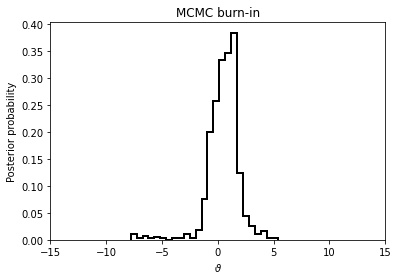

In [27]:
plt.hist(burnin_samples, bins=25, histtype="step", lw=2, color="black", density=True)
plt.title("MCMC burn-in")
plt.xlabel(r"$\vartheta$")
plt.ylabel("Posterior probability")
plt.xlim([-15, 15])
plt.show()

#### Actual chain

In [28]:
num_burnin = 10000

theta = torch.tensor(burnin_samples[-1]) # Take final burnin sample
samples = []
samples.append(theta.item())
for _ in tqdm(range(num_burnin)):
    theta_proposed = propose(theta)
    log_ratio = compute_log_ratio(theta_proposed, theta, x_o)
    ratio = log_ratio.exp()
    u = np.random.random()
    if u <= ratio:
        theta = theta_proposed
        samples.append(theta.item())

100%|██████████| 10000/10000 [00:45<00:00, 221.65it/s]


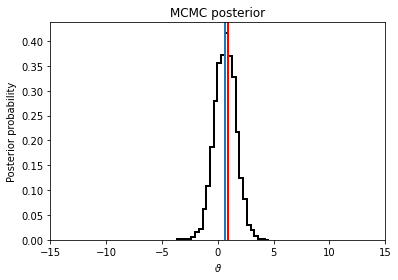

In [29]:
plt.hist(samples, bins=25, histtype="step", lw=2, color="black", density=True)
plt.title("MCMC posterior")
plt.xlabel(r"$\vartheta$")
plt.ylabel("Posterior probability")
plt.axvline(truth, lw=2, color="red", label="Truth")
plt.axvline(x_o, lw=2, color="C0", label="True MAP")
plt.xlim([-15, 15])
plt.show()

## With `hypothesis` (https://github.com/montefiore-ai/hypothesis)

Reprogramming these steps for every individual project is quite cumbersome. I apologize for the absence of documentation, I mainly use to have reproducable components in the projects I work on instead of recoding everything from scratch. We define all the utility functions in the file `ratio_estimation.py`.

In [30]:
import hypothesis

hypothesis.disable_gpu() # Disables the usage of the GPU internally

from hypothesis.visualization.util import make_square

In [31]:
# Cleanup the old data files if they are present
!rm -r estimators

In [32]:
!python -u -m hypothesis.bin.ratio_estimation.train -h

usage: Amortised Approximate Ratio Estimator training [-h] [--data-parallel]
                                                      [--disable-gpu]
                                                      [--out OUT] [--show]
                                                      [--dont-shuffle]
                                                      [--denominator DENOMINATOR]
                                                      [--amsgrad]
                                                      [--batch-size BATCH_SIZE]
                                                      [--conservativeness CONSERVATIVENESS]
                                                      [--clip-grad CLIP_GRAD]
                                                      [--epochs EPOCHS]
                                                      [--logits] [--lr LR]
                                                      [--lrsched]
                                                      [--lrsched-every LRSCHED_EVERY]
          

### Hyperparameters

In [33]:
batch_size = 8192

In [34]:
epochs = 1

In [35]:
learning_rate = 0.0001

In [36]:
num_estimators = 5 # It is typically a good idea to ensemble the ratio estimators to reduce the variance of their approximations

```
python -u -m hypothesis.bin.ratio_estimation.train
           --data-paralle                           # Automatically train the model on multiple GPU's when the resources are available
           --out $path                              # Store the trained models and other metadata in the specified folder
           --show                                   # Show the progress of the training procedure in `stdout`
           --denominator "inputs|outputs"           # Denominator of the training criterion '|' denotes an independence relation. 
                                                    #   -> p(inputs)p(outputs) -> so the ratio it will learn is p(inputs,outputs)/(p(inputs)p(outputs)) 
                                                    #   -> pointwise mutual information
           --batch-size $batch_size                 # Batch size
           --conservativeness 0.0                   # Conservativeness criterion, how much weight should be given to the prior. 
                                                    #  -> Convenient way to impose a conservative estimation. 
                                                    #  -> Setting this value to 1 will result in a posterior that is indistinghuisable from the prior.
           --epochs $epochs                         # Number of epochs
           --lr $learning_rate                      # Learning rate
           --lrsched                                # Enables learning rate scheduling
           --lrsched-every 5                        # Schedule every 5 epochs
           --lrsched-gamma 0.5                      # Decay learning rate every 5 epochs by 0.5
           --weight-decay $weight_decay             # Weight decay, automatically enables the AdamW optimizer.
           --workers 8                              # Number of concurrent data loaders
           --data-train "ratio_estimation.JointTrain"            # Class of the training dataset
           --data-test "ratio_estimation.JointTest"              # Class of the test dataset
           --estimator "ratio_estimation.RatioEstimator"         # Class of the ratio estimator, should accept the keywords defined in `--denominator`.
                                                    #  -> forward(inputs=inputs, outputs=outputs).
```

In [37]:
import os

!mkdir -p estimators

for index in range(num_estimators):
    path = "estimators/" + str(index).zfill(5)
    # Check if the model has been trained
    if not os.path.exists(path + "/best-model.th"):
        print("\nTraining started!")
        !python -u -m hypothesis.bin.ratio_estimation.train \
           --data-parallel \
           --out $path \
           --show \
           --denominator "inputs|outputs" \
           --batch-size $batch_size \
           --epochs $epochs \
           --lr $learning_rate \
           --lrsched \
           --lrsched-every 5 \
           --lrsched-gamma 0.5 \
           --workers 2 \
           --data-train "ratio_estimation.JointTrain" \
           --data-test "ratio_estimation.JointTest" \
           --estimator "ratio_estimation.RatioEstimator"


Training started!
  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/joerih/anaconda/envs/stellar-stream-inference/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Test loss 0.45118929885449954: 100%|██████████████| 1/1 [01:17<00:00, 77.20s/it]
Total epochs:		1
Best training loss:	0.43589580059051514
Final training loss:	0.4490945339202881
Best testing loss:	0.45118929885449954
Best test epoch:	1
Final test loss:	0.45118929885449954

Training started!
  0%|               

### Inference

The training procedure will store several files in the directory specified by `--out`, including the model with the minimum test loss (`best-model.th`).

In [42]:
from ratio_estimation import load_estimator

# Load the trained ratio estimator. The '*' automatically matches all available paths, and will load the ratio estimators as an ensemble.
r = load_estimator("estimators/*/best-model.th").eval()

As before, the posterior is computed as:

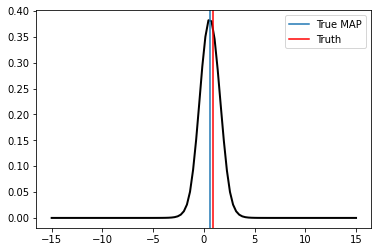

In [39]:
resolution = 100
inputs = torch.linspace(prior.low, prior.high, resolution).view(-1, 1)
outputs = x_o.repeat(resolution).view(-1, 1)
log_ratios = r.log_ratio(inputs=inputs, outputs=outputs) # The specified parameters have to be specified as keywords due to the nature of `--denominator`
log_posterior = prior.log_prob(inputs) + log_ratios.cpu()

plt.plot(inputs.detach(), np.exp(log_posterior.detach()), lw=2, color="black")
plt.axvline(x_o, color="C0", label="True MAP")
plt.axvline(truth, color="red", label="Truth")
plt.legend()
plt.show()

### AALR Metropolis-Hastings

In [45]:
from hypothesis.inference.mcmc import AALRMetropolisHastings
from hypothesis.inference.transition_distribution import Normal as NormalTransition

proposal = NormalTransition(1) # Proposal with unit standard deviation
sampler = AALRMetropolisHastings(prior, r, proposal)

#### Burn-in

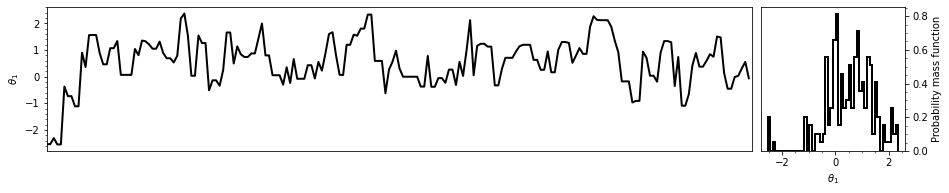

In [46]:
from hypothesis.visualization.mcmc import plot_trace

theta = prior.sample()
burnin_chain = sampler.sample(x_o.view(1, -1), theta, num_samples=200)

figure = plot_trace(burnin_chain)
plt.show()

#### Actual

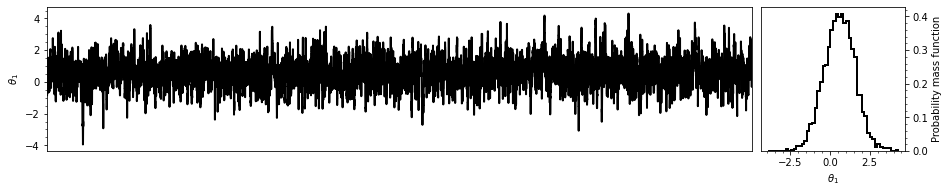

In [47]:
theta = burnin_chain[-1]
chain = sampler.sample(x_o.view(1, 1), theta, num_samples=10000)

figure = plot_trace(chain)
plt.show()

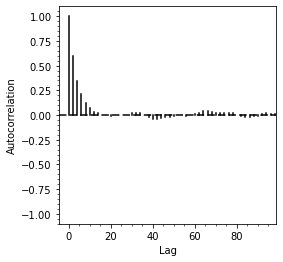

In [48]:
from hypothesis.visualization.mcmc import plot_autocorrelation

figure = plot_autocorrelation(chain, max_lag=100)
plt.show()

In [49]:
print("Effective size:", chain.effective_size())
print("Sampling efficiency:", chain.efficiency())

Effective size: 2354
Sampling efficiency: 0.2354


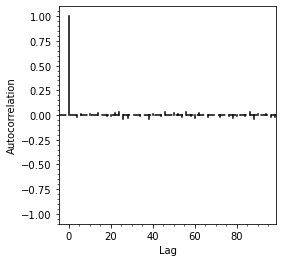

Effective size: 2317
Sampling efficiency: 0.9842820730671198


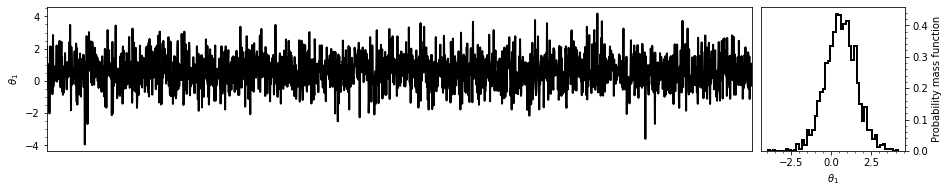

In [50]:
thinned_chain = chain.thin(proportion=chain.efficiency()) # Default behaviour, chain.thin() is equivalent.
figure = plot_autocorrelation(thinned_chain)
plt.show()

print("Effective size:", thinned_chain.effective_size())
print("Sampling efficiency:", thinned_chain.efficiency())

figure = plot_trace(thinned_chain)
plt.show()